# Data Exploration
First we will load the original data from Perez-Almendros et al. (2020) by using their provided DontPatronizeMe-object from their [github-repository](https://github.com/Perez-AlmendrosC/dontpatronizeme).

In [6]:
from dontpatronizeme.ext_dont_patronize_me import DontPatronizeMe

dpm = DontPatronizeMe('data/dontpatronizeme_v1.4/dontpatronizeme_categories.tsv', '')
dpm.load_task2()
dpm.train_task2_df

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


,par_id,art_id,text,keyword,country,label
0,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,"[1, 0, 0, 1, 0, 0, 0]"
1,1279,@@7896098,Pope Francis washed and kissed the feet of Mus...,refugee,ng,"[0, 1, 0, 0, 0, 0, 0]"
2,8330,@@17252299,Many refugees do n't want to be resettled anyw...,refugee,ng,"[0, 0, 1, 0, 0, 0, 0]"
3,4063,@@3002894,"""Budding chefs , like """" Fred """" , """" Winston ...",in-need,ie,"[1, 0, 0, 1, 1, 1, 0]"
4,4089,@@25597822,"""In a 90-degree view of his constituency , one...",homeless,pk,"[1, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...
988,873,@@20374243,Citing the fact that these kids who died at Go...,poor-families,sg,"[1, 0, 0, 0, 1, 0, 0]"
989,10070,@@15573661,Fern ? ndez was a well-known philanthropist wh...,disabled,ng,"[1, 0, 0, 0, 0, 0, 0]"
990,6484,@@2559173,"Touched much by their plight , Commanding Offi...",homeless,lk,"[1, 0, 0, 0, 0, 1, 0]"
991,6249,@@1947926,She reiterated her ministry 's commitment to p...,women,gh,"[1, 0, 0, 0, 0, 0, 0]"


### Explorations + Preparations for the BiLSTM

Because Perez-Almendros et al. (2020) use the GoogleNews word vector embeddings for their BiLSTM model, we will do the same for our BiLSTM in order to increase meaningful comparability across this model type.

In [1]:
from nltk.tokenize import word_tokenize
import pickle
import torch
import numpy as np
import pandas as pd

Please note: the following code will only work, when providing the 'GoogleNews-vectors-negative300.bin' in the data folder (src/data). We have not submitted this file in the repository for memory reasons. You can download the file from this page <https://code.google.com/archive/p/word2vec/> by following this link: <https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing>

In [2]:
from os.path import exists

if not exists("data/GoogleNews-vectors-negative300.bin"):
    raise FileNotFoundError('The following three cells will not work,' + 
                            'please download the GoogleNews-vectors-negative300.bin file ' +
                            '(please read the paragraph above for instructions.)' + 
                            'or skip the next three cells and continue running from there.')

In [3]:
# get word vectors from GoogleNews vectors
from gensim.models import KeyedVectors
wv_from_bin = KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True)  

First, we'll check how well the given GoogleNews embeddings mirror the tokens we have in our dataset:

In [12]:
# get tokens from dataset
token_collection = set()
for i in range(len(dpm.train_task2_df)):
    # tokenise input
    t = set(word_tokenize(dpm.train_task2_df.loc[i, "text"]))
    # add tokens to vocabulary set
    token_collection.update(t)

# check which words aren't covered by GoogleNews embeddings
# create list for collecting unknown words
unk = []
for token in token_collection:
    if token not in wv_from_bin:
        unk.append(token)
print(unk)

['Mwadena', 'publicly-funded', '1920', '276', '1,488', 'story-sharing', 'inner-city', 'man-made', '1973', 'Ecclessiastes', 'Iran-aligned', 'vulnerables', 'behaviour', 'armoured', ';', 'Food-Co', 'muscle-bound', 'Gongera', 'Kanakapuram', 'sub-humans', 'Poranu', 'organising', 'organisation', 'eco-friendly', 'xBD', '2010', '280,000', 'custom-made', 'UCRT', '16xOSU', 'Bhikkhuni', '2,500', 'Abayage', '1,200', 'high-profile', 'Utkaliya', 'information-based', 'Secretary-General', '-wage', 'start-up', '1922', '1,500', 'well-being', '10', 'gun-toting', 'brutalising', '5,000', '1,00,000', 'honourable', '204,000', 'Kotleba-People', 'Tablet-based', 'far-fetched', 'barrier-free', 'Samhua', '25', 'Getty/Instagram', 'marginalisation', 'Nwaochi', 'Keshap', 'U.K', 'brutalised', 'instability/shifting', 'MOTHs', '19th', 'Dharga', 'jewellery', 'specialised', '450', '14', '1/4', '386', 'accessiblility', '400', 'mothers-', 'mater-', '1993', 'Kaveke', 'Elfreeda', 'Non-action', 'of', '5000', '29', 'Upworthy',

We notice a couple of trends: Firstly, tokens that still contain punctuation (- or / or . -- see for example 'poverty-stricken', 'life-changing', 'ill-educated', 'refugee/migrant', 'S/he', 'U.K') are not recognised as words -- this is something that we can circumnavigate with a different kind of preprocessing. What we cannot change is that GoogleNews does not recognise British English spelling (e.g. 'modernisation', 'marginalisation', 'patronise') and also seems to have trouble with some proper names ('DUSIB', 'TheDignityProject', 'Mumassaba') and numbers (e.g. '400,000', '2010'). 

Since the GoogleNews word embeddings file is rather large and it is unlikely that we will encounter all of its >100 billion words, we will build our own embedding vocabulary that focuses on the embeddings we actually need.

In [4]:
# Create BiLSTM Vocabulary

# initialise vocab set
vocab = set()
# get every vocab item from dataset
# tokenize the text paragraphs and collect vocabulary items in set
for i in range(len(dpm.train_task2_df)):
    # replace . and - and / with whitespace (to increase recognised words)
    words = dpm.train_task2_df.loc[i, "text"].replace("-", " ").replace("/", " ").replace(".", " ")
    # tokenise input
    t = set(word_tokenize(words))
    # add tokens to vocabulary set
    vocab.update(t)

# create dictionary: key = vocab item, value = GoogleNews vector
# initialise lookup dictionary
lookup_dict = {}
# iterate through vocab and look up vector embeddings from google; create dict entry
for word in vocab:
    if word in wv_from_bin:
        lookup_dict[word] = wv_from_bin.get_vector(word)
# update vocabulary to be able to handle padding later on
vocabulary = dict()
vocabulary[""] = np.zeros(300)
vocabulary["[UNK]"] = np.zeros(300)
vocabulary = dict(**vocabulary,**lookup_dict)

# save lookup dictionary as pickle object for future use
pklobj = open("data/embeddings_dict.obj","wb")
pickle.dump(vocabulary,pklobj)
pklobj.close()

Please note: the following code will now work again properly without the GoogleNews-embeddings-file.

Next, we turn our vocabulary from a dictionary form into an embedding matrix that we can later use as reference for our BiLSTM.

In [48]:
# load vocabulary dict
lookup_dict = pickle.load(open('data/embeddings_dict.obj','rb'))

# turn lookup_dict into an embedding matrix
emb_matrix = np.zeros((len(lookup_dict),300))
for key in lookup_dict:
    emb_matrix[look_up(key)] = lookup_dict[key]
emb_matrix = torch.from_numpy(emb_matrix)

Save embedding matrix as pickle object for future use:

In [32]:
pklobj = open("data/embeddings_matrix.obj","wb")
pickle.dump(emb_matrix,pklobj)
pklobj.close()

torch.Size([8237, 300])

For modelling the BiLSTM it is useful for the input sequences to have the same length. Therefore, we will explore which length marks a good maximum length for sequences.

In [5]:
# import our embedding helper functions
import embedding_functions as ef

# find out about paragraph lengths
lens = []
lens_short = []
for i in range(len(dpm.train_task2_df)):
    lens.append(len(word_tokenize(dpm.train_task2_df.loc[i, "text"]))) # paragraph lengths
    lens_short.append(len(ef.inp2array(dpm.train_task2_df.loc[i, "text"]))) # paragraph lengths after removing "invalid" tokens

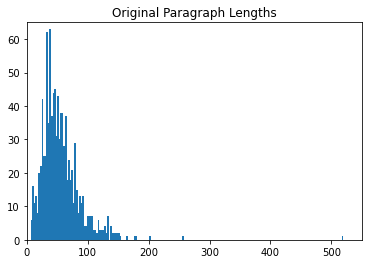

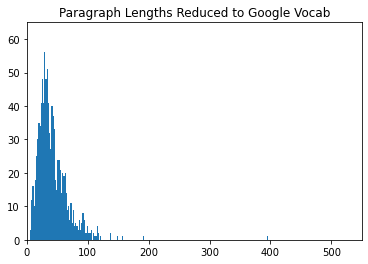

In [9]:
# visualise paragraph lengths

import matplotlib.pyplot as plt

plt.figure(1)
plt.hist(lens, bins=200)

plt.ylim(0,65)
plt.xlim(0,550)
plt.title("Original Paragraph Lengths")

plt.figure(2)
plt.hist(lens_short, bins=200)
plt.ylim(0,65)
plt.xlim(0,550)
plt.title("Paragraph Lengths Reduced to Google Vocab")
plt.show()

In [8]:
print("Max paragraph length (original): ",max(lens))
print("Min paragraph length (original): ",min(lens))
print("Mean paragraph length (original): ",np.mean(lens))
print("Max paragraph length (recognisable tokens only): ",max(lens_short))
print("Min paragraph length (recognisable tokens only): ",min(lens_short))
print("Mean paragraph length (recognisable tokens only): ",np.mean(lens_short))

Max paragraph length (original):  520
Min paragraph length (original):  6
Mean paragraph length (original):  55.18831822759315
Max paragraph length (recognisable tokens only):  396
Min paragraph length (recognisable tokens only):  5
Mean paragraph length (recognisable tokens only):  41.74219536757301


There is one outlier paragraph which is more than twice as long as all the other paragraphs: paragraph ID 6833. Since it is not labelled with an underrepresented category (eg. "The poorer, the merrier"), we decided to remove it from our input data in order to avoid unnecessarily extensive padding to the other input sequences.

In [62]:
train_task2_cleaned_df = dpm.train_task2_df.drop(dpm.train_task2_df[dpm.train_task2_df.par_id=="6833"].index)
                                            .reset_index(drop=True)

Save new dataframe as csv for future use:

In [63]:
train_task2_cleaned_df.to_csv('data/task2_cleaned.csv')

Now we check again the maximum paragraph length:

In [50]:
# find out about paragraph lengths
lens = []
for i in range(len(train_task2_cleaned_df)):
    lens.append(len(ef.inp2array(train_task2_cleaned_df.loc[i, "text"]))) # paragraph lengths after removing "invalid" tokens
print("Max paragraph length: ",max(lens))
print("Min paragraph length: ",min(lens))
print("Mean paragraph length: ",np.mean(lens))

Max paragraph length:  191
Min paragraph length:  5
Mean paragraph length:  41.38508064516129


Since -- when only considering the words that our vocabulary built on the GoogleNews vector embeddings recognises -- the maximum length of paragraphs is a managable 191, we choose this number as our maximum sequence length for our BiLSTM model and will pad each other input sequence accordingly.

# Adding Higher Level Label Information
We would like to find out whether the higher level labels of the PCL taxonomy given ('The saviour', 'The expert', and 'The poet') are easier to predict than the lower level labels. Therefor, we will infer the higher level labels from the lower level labels:
- 1 - 2: Unbalanced Power Relations, Shallow Solution -> The saviour
- 3 - 4: Presupposition, Authority Voice -> The expert
- 5 - 7: Metaphor, Compassion, The poorer the merrier -> The poet

In [132]:
# load cleaned data, convert labels to lists

import pandas, ast, numpy as np

train_task2_cleaned_df = pandas.read_csv('data/task2_cleaned.csv', index_col = 0)
labels = train_task2_cleaned_df.loc[:, 'label'].to_numpy()
labels = list([list(ast.literal_eval(x)) for x in labels])
train_task2_cleaned_df['label'] = labels
train_task2_cleaned_df

,par_id,art_id,text,keyword,country,label
0,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,"[1, 0, 0, 1, 0, 0, 0]"
1,1279,@@7896098,Pope Francis washed and kissed the feet of Mus...,refugee,ng,"[0, 1, 0, 0, 0, 0, 0]"
2,8330,@@17252299,Many refugees do n't want to be resettled anyw...,refugee,ng,"[0, 0, 1, 0, 0, 0, 0]"
3,4063,@@3002894,"""Budding chefs , like """" Fred """" , """" Winston ...",in-need,ie,"[1, 0, 0, 1, 1, 1, 0]"
4,4089,@@25597822,"""In a 90-degree view of his constituency , one...",homeless,pk,"[1, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...
987,873,@@20374243,Citing the fact that these kids who died at Go...,poor-families,sg,"[1, 0, 0, 0, 1, 0, 0]"
988,10070,@@15573661,Fern ? ndez was a well-known philanthropist wh...,disabled,ng,"[1, 0, 0, 0, 0, 0, 0]"
989,6484,@@2559173,"Touched much by their plight , Commanding Offi...",homeless,lk,"[1, 0, 0, 0, 0, 1, 0]"
990,6249,@@1947926,She reiterated her ministry 's commitment to p...,women,gh,"[1, 0, 0, 0, 0, 0, 0]"


In [133]:
# infer higher level labels based on the given lower level labels
hl_labels = []
for row in train_task2_cleaned_df.itertuples():
    label = row[-1]
    row_hl_labels = [0, 0, 0]
    if sum(label[0:2]) >= 1:
        row_hl_labels[0] = 1
    if sum(label[2:4]) >= 1:
        row_hl_labels[1] = 1
    if sum(label[4:]) >= 1:
        row_hl_labels[2] = 1
    if sum(row_hl_labels) == 0:
        raise Error('Inferred higher level labels sum up to 0!')
    hl_labels.append(row_hl_labels)
hl_labels[0:5]

[[1, 1, 0], [1, 0, 0], [0, 1, 0], [1, 1, 1], [1, 0, 0]]

In [134]:
# add inferred higher level labels to data
train_task2_cleaned_df['higher level label'] = hl_labels
train_task2_cleaned_df

,par_id,art_id,text,keyword,country,label,higher level label
0,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,"[1, 0, 0, 1, 0, 0, 0]","[1, 1, 0]"
1,1279,@@7896098,Pope Francis washed and kissed the feet of Mus...,refugee,ng,"[0, 1, 0, 0, 0, 0, 0]","[1, 0, 0]"
2,8330,@@17252299,Many refugees do n't want to be resettled anyw...,refugee,ng,"[0, 0, 1, 0, 0, 0, 0]","[0, 1, 0]"
3,4063,@@3002894,"""Budding chefs , like """" Fred """" , """" Winston ...",in-need,ie,"[1, 0, 0, 1, 1, 1, 0]","[1, 1, 1]"
4,4089,@@25597822,"""In a 90-degree view of his constituency , one...",homeless,pk,"[1, 0, 0, 0, 0, 0, 0]","[1, 0, 0]"
...,...,...,...,...,...,...,...
987,873,@@20374243,Citing the fact that these kids who died at Go...,poor-families,sg,"[1, 0, 0, 0, 1, 0, 0]","[1, 0, 1]"
988,10070,@@15573661,Fern ? ndez was a well-known philanthropist wh...,disabled,ng,"[1, 0, 0, 0, 0, 0, 0]","[1, 0, 0]"
989,6484,@@2559173,"Touched much by their plight , Commanding Offi...",homeless,lk,"[1, 0, 0, 0, 0, 1, 0]","[1, 0, 1]"
990,6249,@@1947926,She reiterated her ministry 's commitment to p...,women,gh,"[1, 0, 0, 0, 0, 0, 0]","[1, 0, 0]"


# Train/Test Splitting
Next, we need to split our dataset into our own train and a test set, as only the pure train set from the original dataset has been provided yet.

We could do a stratified split by distributing the different vulnerable groups by their shares of the whole dataset:

In [135]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train_task2_cleaned_df, test_size=0.2, random_state = 1, 
                               stratify=train_task2_cleaned_df['keyword'])

In [136]:
train

,par_id,art_id,text,keyword,country,label,higher level label
934,1309,@@3363505,""""""" With huge shortages of funding and wide ga...",in-need,ca,"[0, 0, 0, 0, 0, 1, 0]","[0, 0, 1]"
297,282,@@4649746,Why is the voting turn-out so poor in rich cou...,homeless,bd,"[1, 0, 1, 1, 0, 0, 0]","[1, 1, 0]"
201,10352,@@21102155,The next immediate problem that cropped up was...,poor-families,lk,"[1, 0, 0, 0, 0, 1, 0]","[1, 0, 1]"
369,8495,@@4567045,He stressed for extricating the poorest from t...,poor-families,pk,"[1, 0, 0, 0, 1, 1, 0]","[1, 0, 1]"
316,5432,@@3826227,"' A large-scale , publicly-funded energy effic...",vulnerable,gb,"[1, 0, 0, 1, 0, 0, 0]","[1, 1, 0]"
...,...,...,...,...,...,...,...
912,5430,@@22646577,It is the government 's duty to ensure homeles...,homeless,hk,"[1, 0, 0, 0, 0, 0, 0]","[1, 0, 0]"
770,2996,@@23945440,Local leaders led by area Member of County Ass...,poor-families,ke,"[1, 1, 0, 0, 0, 0, 0]","[1, 0, 0]"
523,7104,@@18693604,"When you see others in need , support them .",in-need,nz,"[1, 0, 0, 0, 0, 0, 0]","[1, 0, 0]"
528,1619,@@18984294,""""""" By donating blood , many lives are saved a...",hopeless,ng,"[1, 1, 1, 0, 0, 1, 0]","[1, 1, 1]"


In [137]:
train_size = train.groupby('keyword').size()
test_size = test.groupby('keyword').size()
test_size/train_size

keyword
disabled         0.246154
homeless         0.253521
hopeless         0.252525
immigrant        0.250000
in-need          0.248227
migrant          0.250000
poor-families    0.250000
refugee          0.246377
vulnerable       0.250000
women            0.268293
dtype: float64

We can see that this results in a very nice, equally distributed ratio of 1:4 for all 10 keywords. But, as we only have very few instances of some PCL categories, we decided to split the dataset according to a stratified sampling of the PCL categories. Therefore, we need a different approach that can handle multilabel stratification:

In [138]:
data = train_task2_cleaned_df.loc[:, 'label']
data

0      [1, 0, 0, 1, 0, 0, 0]
1      [0, 1, 0, 0, 0, 0, 0]
2      [0, 0, 1, 0, 0, 0, 0]
3      [1, 0, 0, 1, 1, 1, 0]
4      [1, 0, 0, 0, 0, 0, 0]
               ...          
987    [1, 0, 0, 0, 1, 0, 0]
988    [1, 0, 0, 0, 0, 0, 0]
989    [1, 0, 0, 0, 0, 1, 0]
990    [1, 0, 0, 0, 0, 0, 0]
991    [0, 0, 0, 1, 0, 0, 0]
Name: label, Length: 992, dtype: object

In [139]:
# converting labels to numpy arrays
Y = np.array([list(x) for x in data])

In [140]:
Y

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [141]:
# we only get 2069 'instances' of PCL as opposed to the 2760 instances labelled in the dataset
# because multiple instances of the same label in one paragraph are only counted once
Y.sum()

2069

In [142]:
# Multilabel stratification splitting
from skmultilearn.model_selection import IterativeStratification
X = train_task2_cleaned_df
stratifier = IterativeStratification(n_splits=2, order=1, sample_distribution_per_fold=[0.2, 0.8])
train_indexes, test_indexes = next(stratifier.split(X, Y))
X_train, Y_train = X.loc[train_indexes], Y[train_indexes]
X_test, Y_test = X.loc[test_indexes], Y[test_indexes]

In [143]:
X_train, Y_train, X_test, Y_test

(     par_id      art_id                                               text  \
 1      1279   @@7896098  Pope Francis washed and kissed the feet of Mus...   
 3      4063   @@3002894  "Budding chefs , like "" Fred "" , "" Winston ...   
 6      4177    @@930041  The Word of God is truth that 's living and ab...   
 7      3963  @@18867357  Chantelle Owens , Mrs Planet 2016 , hosted the...   
 8      2001  @@14012804  t is remiss not to mention here that not all s...   
 ..      ...         ...                                                ...   
 987     873  @@20374243  Citing the fact that these kids who died at Go...   
 988   10070  @@15573661  Fern ? ndez was a well-known philanthropist wh...   
 989    6484   @@2559173  Touched much by their plight , Commanding Offi...   
 990    6249   @@1947926  She reiterated her ministry 's commitment to p...   
 991    5149   @@1789214  Preaching the sermon , the Dean of the St. Pet...   
 
            keyword country                  label

In [144]:
Y_test.sum(axis=0),Y_train.sum(axis=0)

(array([143,  39,  45,  46,  39,  94,  10]),
 array([572, 157, 179, 183, 158, 374,  30]))

In [145]:
Y_test.sum(axis=0)/Y_train.sum(axis=0)

array([0.25      , 0.24840764, 0.25139665, 0.25136612, 0.24683544,
       0.2513369 , 0.33333333])

This shows us the distribution of the categories across train and test data. We can see that for all categories we get a ratio of roughly 1:4, with the last category having 1:3 due to fewer samples in this category.

In [146]:
print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 815
Test size: 177


Save training and testing data as csv for future use:

In [147]:
X_train.to_csv('data/dpm_train.csv')

In [148]:
X_test.to_csv('data/dpm_test.csv')